In [2]:
import os

# Set the TensorFlow logging level to suppress INFO, WARNING, and ERROR messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
import absl.logging

# Set the absl logging level to ERROR
absl.logging.set_verbosity(absl.logging.ERROR)

# from tensorflow.keras import layers, models
from keras import layers, models

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Using GPU")
else:
    print("Using CPU")

for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

Using GPU


In [3]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
data_dir = Path('data')
male_voices_path = data_dir / 'males'
female_voices_path = data_dir / 'females'

male_voices = list(map(str, male_voices_path.glob('*.wav')))
female_voices = list(map(str, female_voices_path.glob('*.wav')))
audio_paths = male_voices + female_voices
len(male_voices), len(female_voices), len(audio_paths)

(3682, 2311, 5993)

In [5]:
# @tf.function
def load_wav(filename):
    if isinstance(filename, bytes):
        filename = filename.decode('utf-8')
        
    # tf.print(f"Loading file: {filename}")
    file_content = tf.io.read_file(filename=filename)
    wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    # removing tailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # goes from 44100Hz to 16000 Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

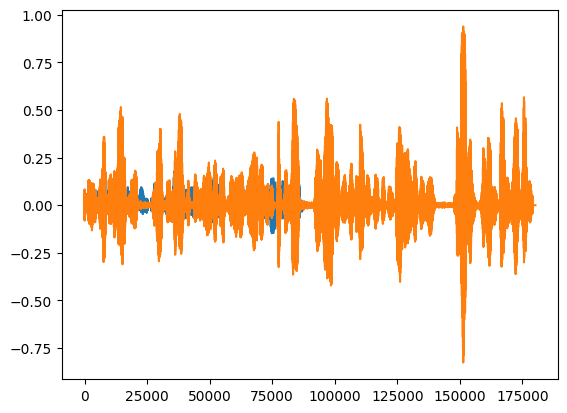

In [7]:
wav_m = load_wav(male_voices[0])
wav_f = load_wav(female_voices[0])
plt.plot(wav_m)
plt.plot(wav_f)
plt.show();

# Creating TF Dataset

In [8]:
male_voices_path = "data/males"
female_voices_path = "data/females"

voices_m = tf.data.Dataset.list_files(male_voices_path+'/*.wav')
voices_f = tf.data.Dataset.list_files(female_voices_path+'/*.wav')

In [9]:
voices_m.as_numpy_iterator().next()

b'data/males/2675.wav'

# Adding Labels
- 1 -> Males
- 0 -> Females

In [10]:
males = tf.data.Dataset.zip((voices_m, tf.data.Dataset.from_tensor_slices(tf.ones(len(voices_m)))))
females = tf.data.Dataset.zip((voices_f, tf.data.Dataset.from_tensor_slices(tf.zeros(len(voices_f)))))
data = males.concatenate(females)

In [11]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
data.shuffle(3000).as_numpy_iterator().next()

(b'data/males/596.wav', 1.0)

# EDA
- hahaha

In [141]:
audio_paths = list(map(str, audio_paths))

lengths = []
for file in audio_paths:
    t_wav = load_wav(file)
    lengths.append(len(t_wav))

In [143]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=111928>

In [144]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=63488>

In [145]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=1456128>

# Preprocessing

In [252]:
# @tf.function(retain_metadata=True)
def preprocess(filepath, label):
    wav = load_wav(filepath)
    wav = wav[:63488]
    zero_padding = tf.zeros([63488] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # shrot time furriar transform
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram, label

In [253]:
data.as_numpy_iterator().next()

(b'data/males/1313.wav', 1.0)

In [13]:
import tensorflow as tf

# Define the fixed number of frames
fixed_num_frames = 492

def mfcc(filename, label):
    wav = tf.py_function(load_wav, [filename], tf.float32)
    wav.set_shape([None])
    pcm = wav[:63488]
    zero_padding = tf.zeros([63488] - tf.shape(pcm), dtype=tf.float32)
    pcm = tf.concat([pcm, zero_padding], 0)
    stfts = tf.signal.stft(pcm, frame_length=640, frame_step=128)
    spectrogram = tf.abs(stfts)
    spectrogram.set_shape([None, None])
    num_spectrogram_bins = tf.shape(spectrogram)[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 1000.0, 7600.0, 40

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=16000,
        lower_edge_hertz=lower_edge_hertz,
        upper_edge_hertz=upper_edge_hertz
    )

    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate([num_mel_bins]))

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :13]

    # Add a singleton dimension to represent the channel
    mfccs = tf.expand_dims(mfccs, axis=-1)

    # Truncate or pad to a fixed number of frames
    mfccs = mfccs[:fixed_num_frames, :, :]
    mfccs = tf.image.resize_with_crop_or_pad(mfccs, fixed_num_frames, 13)
    
    return mfccs, label


In [14]:
data.map(mfcc)

<_MapDataset element_spec=(TensorSpec(shape=(492, 13, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

(492, 13, 1)


<Figure size 6000x4000 with 0 Axes>

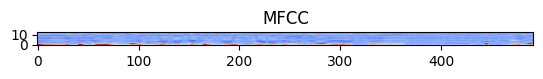

In [16]:
import random
rand_wav, _ = mfcc(audio_paths[random.randint(0, len(audio_paths))], 0)
print(rand_wav.shape)

import numpy as np
plt.figure(figsize=(60, 40))
fig, ax = plt.subplots()
mfcc_data= np.swapaxes(rand_wav , 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap='coolwarm', origin='lower')
ax.set_title('MFCC')

plt.show();

# Plotting Spectogram

In [96]:
def plot_spec(dataset):
    filepath, label = dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()

    spectogram, label = preprocess(filepath=filepath, label=label)
    print(spectogram.shape)

    plt.figure(figsize=(30, 20))
    plt.imshow(tf.transpose(spectogram)[0])
    plt.show();

(1975, 257, 1)


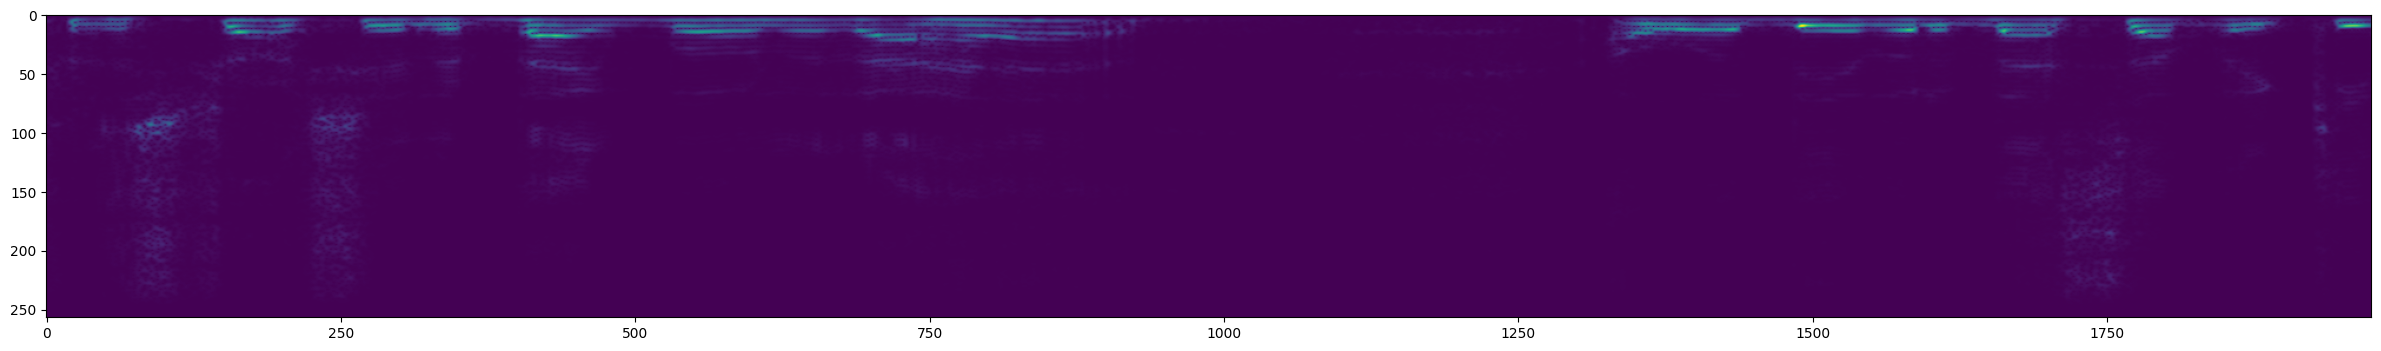

(1975, 257, 1)


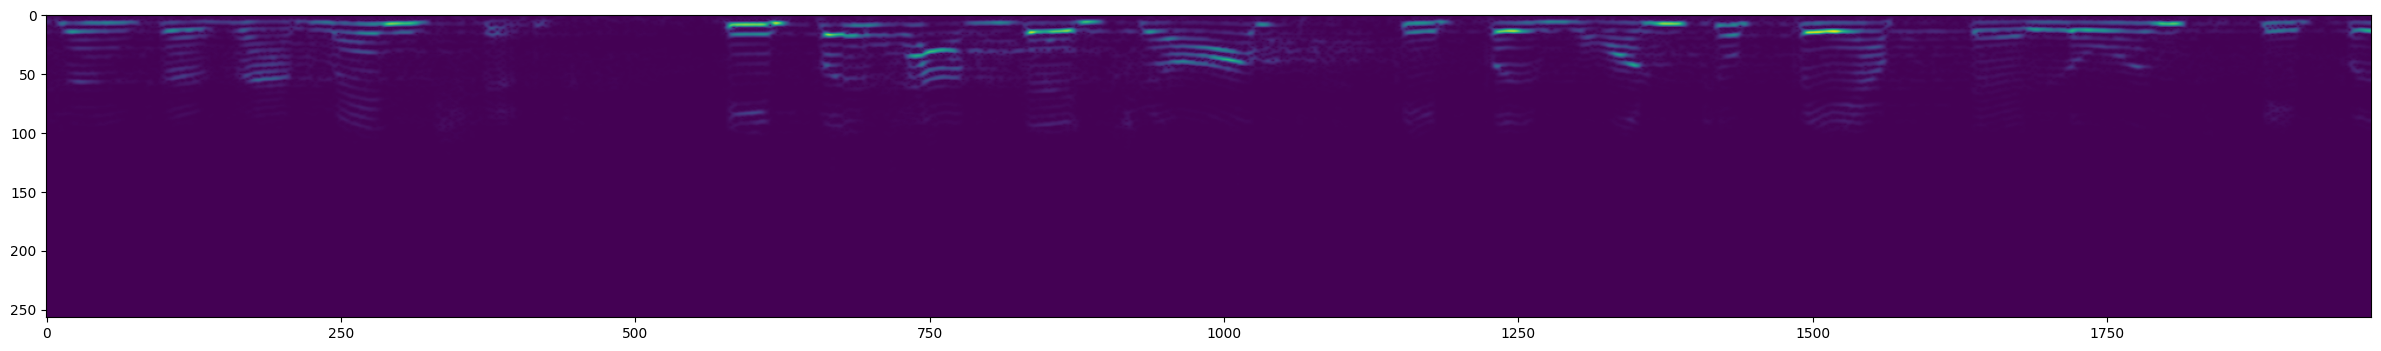

In [97]:
plot_spec(males)
plot_spec(females)

# Create TF Data Pipeline

In [22]:
data_ = data.map(mfcc)
data_ = data_.shuffle(buffer_size=500)
data_ = data_.batch(8)
data_ = data_.prefetch(buffer_size=4)
# data_ = data_.cache()

In [23]:
len(data_) - 525

225

In [24]:
data_

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 492, 13, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [47]:
train = data_.take(525).cache()
test = data_.skip(525).take(225).cache()
# train.cache().repeat()
# test.cache().repeat()

In [48]:
for x, y in train.take(1):
    print("Input shape:", x.shape)
    print("Label shape:", y.shape)

2024-08-12 21:29:51.251597: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Input shape: (8, 492, 13, 1)
Label shape: (8,)


In [61]:
for x, y in test.take(1):
    print("Input shape:", x.shape)
    print("Label shape:", y.shape)

Input shape: (8, 492, 13, 1)
Label shape: (8,)


# Deep Learning Model

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Input, Lambda
import keras

In [71]:
model = Sequential([
    Input(shape=(492, 13, 1)),  
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [72]:
model.compile('Adam',
               loss='binary_crossentropy', 
               metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()] # have to use f1 score average : micro | macro
               )

In [73]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 490, 11, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 245, 5, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 243, 3, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 121, 1, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 968)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       124,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,825 (487.60 KB)

 Trainable params: 124,825 (487.60 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9859 - loss: 0.0326 - precision_2: 0.9934 - recall_1: 0.9916 - val_accuracy: 0.9320 - val_loss: 0.3575 - val_precision_2: 0.2000 - val_recall_1: 0.3559
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9731 - loss: 0.0649 - precision_2: 0.9943 - recall_1: 0.9782 - val_accuracy: 0.8929 - val_loss: 0.2851 - val_precision_2: 0.1818 - val_recall_1: 0.6441
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9836 - loss: 0.0443 - precision_2: 0.9943 - recall_1: 0.9887 - val_accuracy: 0.9080 - val_loss: 0.2391 - val_precision_2: 0.2056 - val_recall_1: 0.6271
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0414 - precision_2: 0.9960 - recall_1: 0.9916 - val_accuracy: 0.9024 - val_loss: 0.2162 - val_precision_2: 0.1947 - val_recall_1: 0.6271
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9918 - loss: 0.0326 - precision_2: 0.9971 - recall_1: 0.9943 -

In [75]:
models = Path('models')
models.mkdir(exist_ok=True, parents=True)

model.save(models / 'model_3.h5')

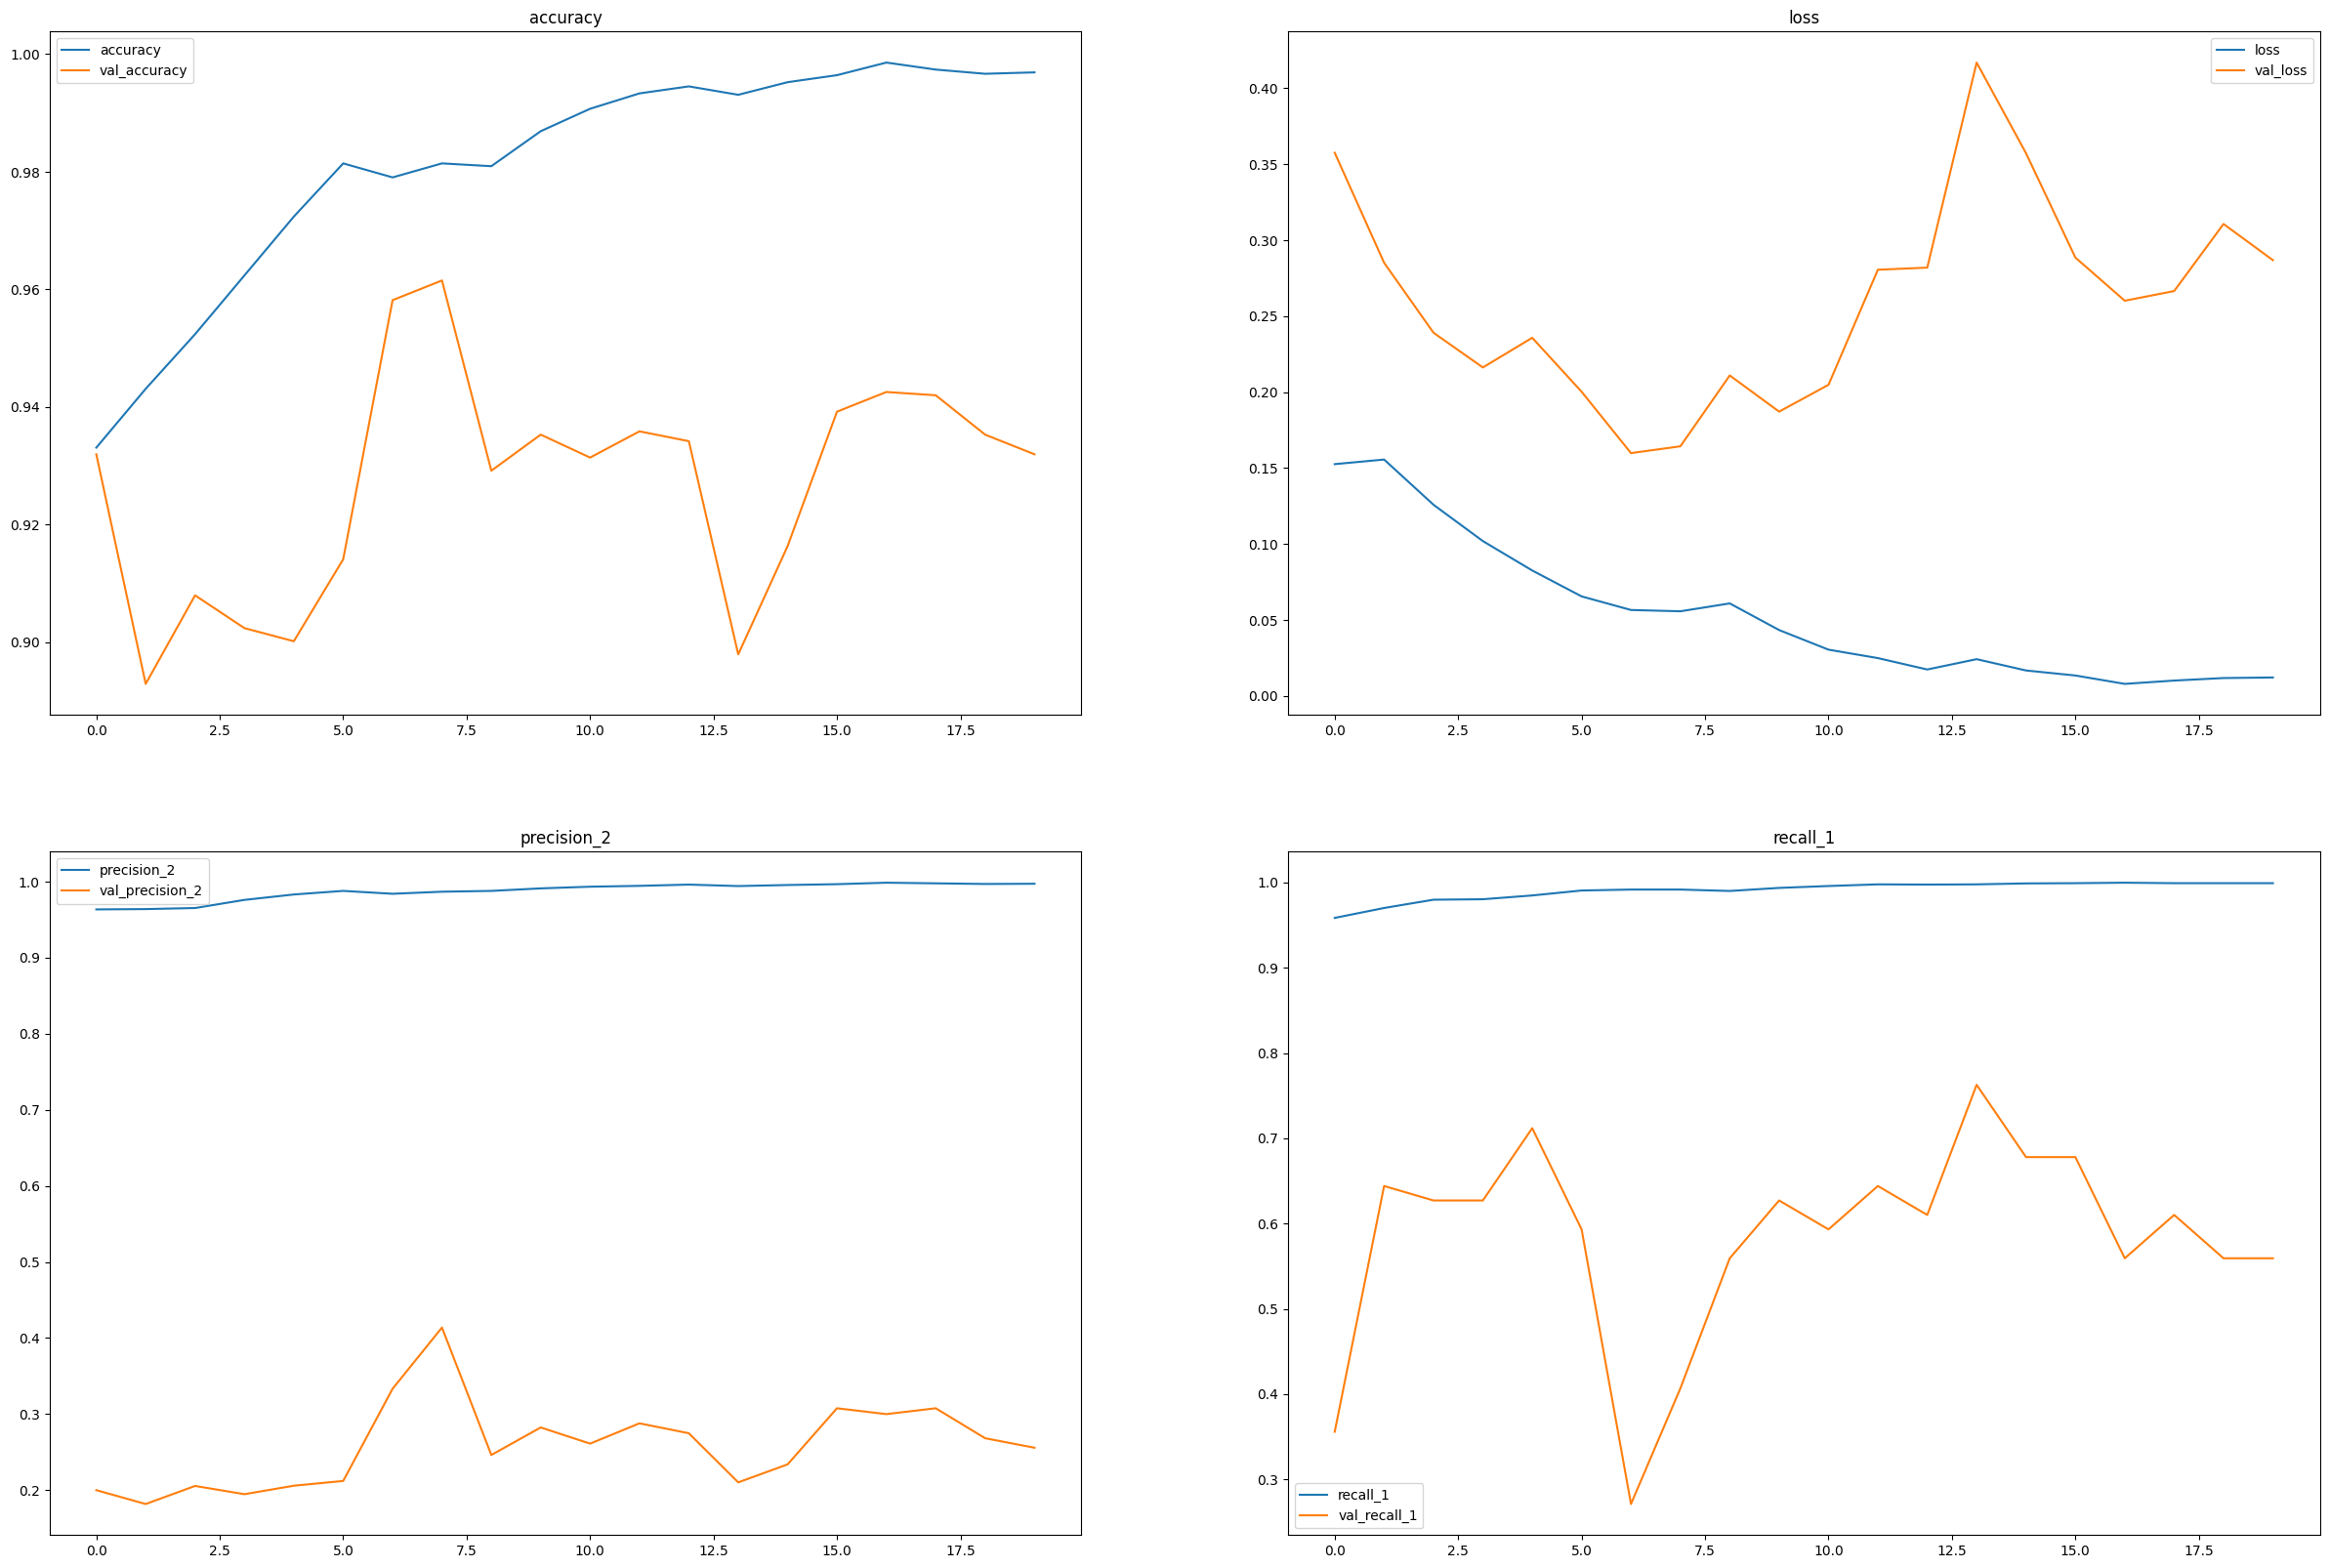

In [91]:
plots = len(hist.history) // 2
assert plots * 2 == len(hist.history)
keys = list(hist.history.keys())

fig, axs = plt.subplots(plots//2, 2, figsize=(30, 20))
for i in range(plots):
    if i % 2 == 0:
        axs[i//2, 0].plot(hist.history[keys[i]])
        axs[i//2, 0].plot(hist.history[keys[i + plots]])
        axs[i//2, 0].set_title(keys[i])
        axs[i//2, 0].legend((keys[i], keys[i + plots]))
    else:
        axs[i//2, 1].plot(hist.history[keys[i]])
        axs[i//2, 1].plot(hist.history[keys[i + plots]])
        axs[i//2, 1].set_title(keys[i])
        axs[i//2, 1].legend((keys[i], keys[i + plots]))
plt.show()